In [ ]:
from keras import layers
import keras
import keras.backend as K

import numpy as np
import seaborn as sns

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Models

In [ ]:
width = 64
height = 64
channels = 1

## Generators Encoder


In [ ]:
input_layer = layers.Input(name='input', shape=(height, width, channels))

# Encoder
x = layers.Conv2D(32, (5,5), strides=(1,1), padding='same', name='conv_1', kernel_regularizer = 'l2')(input_layer)
x = layers.LeakyReLU(name='leaky_1')(x)

x = layers.Conv2D(64, (3,3), strides=(2,2), padding='same', name='conv_2', kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(name='norm_1')(x)
x = layers.LeakyReLU(name='leaky_2')(x)


x = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='conv_3', kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(name='norm_2')(x)
x = layers.LeakyReLU(name='leaky_3')(x)


x = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='conv_4', kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(name='norm_3')(x)
x = layers.LeakyReLU(name='leaky_4')(x)

x = layers.GlobalAveragePooling2D(name='g_encoder_output')(x)

g_e = keras.models.Model(inputs=input_layer, outputs=x)

g_e.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 64, 64, 1)         0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 64, 64, 32)        832       
_________________________________________________________________
leaky_1 (LeakyReLU)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 32, 32, 64)        18496     
_________________________________________________________________
norm_1 (BatchNormalization)  (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_2 (LeakyReLU)          (None, 32, 32, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 16, 16, 128)       7385

## Generator

In [ ]:
input_layer = layers.Input(name='input', shape=(height, width, channels))

x = g_e(input_layer)

y = layers.Dense(width * width * 2, name='dense')(x) # 2 = 128 / 8 / 8
y = layers.Reshape((width//8, width//8, 128), name='de_reshape')(y)

y = layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', name='deconv_1', kernel_regularizer = 'l2')(y)
y = layers.LeakyReLU(name='de_leaky_1')(y)

y = layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', name='deconv_2', kernel_regularizer = 'l2')(y)
y = layers.LeakyReLU(name='de_leaky_2')(y)

y = layers.Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', name='deconv_3', kernel_regularizer = 'l2')(y)
y = layers.LeakyReLU(name='de_leaky_3')(y)

y = layers.Conv2DTranspose(channels, (1, 1), strides=(1,1), padding='same', name='decoder_deconv_output', kernel_regularizer = 'l2', activation='tanh')(y)

g = keras.models.Model(inputs=input_layer, outputs=y)

g.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 64, 64, 1)         0         
_________________________________________________________________
model_1 (Model)              (None, 128)               242048    
_________________________________________________________________
dense (Dense)                (None, 8192)              1056768   
_________________________________________________________________
de_reshape (Reshape)         (None, 8, 8, 128)         0         
_________________________________________________________________
deconv_1 (Conv2DTranspose)   (None, 16, 16, 128)       147584    
_________________________________________________________________
de_leaky_1 (LeakyReLU)       (None, 16, 16, 128)       0         
_________________________________________________________________
deconv_2 (Conv2DTranspose)   (None, 32, 32, 64)        7379

## Encoder

In [ ]:
input_layer = layers.Input(name='input', shape=(height, width, channels))

z = layers.Conv2D(32, (5,5), strides=(1,1), padding='same', name='encoder_conv_1', kernel_regularizer = 'l2')(input_layer)
z = layers.LeakyReLU()(z)

z = layers.Conv2D(64, (3,3), strides=(2,2), padding='same', name='encoder_conv_2', kernel_regularizer = 'l2')(z)
z = layers.BatchNormalization(name='encoder_norm_1')(z)
z = layers.LeakyReLU()(z)


z = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='encoder_conv_3', kernel_regularizer = 'l2')(z)
z = layers.BatchNormalization(name='encoder_norm_2')(z)
z = layers.LeakyReLU()(z)

z = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='conv_41', kernel_regularizer = 'l2')(z)
z = layers.BatchNormalization(name='encoder_norm_3')(z)
z = layers.LeakyReLU()(z)

z = layers.GlobalAveragePooling2D(name='encoder_output')(z)

encoder = keras.models.Model(input_layer, z)
encoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 64, 64, 1)         0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 64, 64, 32)        832       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 32, 32, 64)        18496     
_________________________________________________________________
encoder_norm_1 (BatchNormali (None, 32, 32, 64)        256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
encoder_conv_3 (Conv2D)      (None, 16, 16, 128)       7385

## feature extractor

In [ ]:
input_layer = layers.Input(name='input', shape=(height, width, channels))

f = layers.Conv2D(32, (5,5), strides=(1,1), padding='same', name='f_conv_1', kernel_regularizer = 'l2')(input_layer)
f = layers.LeakyReLU(name='f_leaky_1')(f)

f = layers.Conv2D(64, (3,3), strides=(2,2), padding='same', name='f_conv_2', kernel_regularizer = 'l2')(f)
f = layers.BatchNormalization(name='f_norm_1')(f)
f = layers.LeakyReLU(name='f_leaky_2')(f)


f = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='f_conv_3', kernel_regularizer = 'l2')(f)
f = layers.BatchNormalization(name='f_norm_2')(f)
f = layers.LeakyReLU(name='f_leaky_3')(f)


f = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='f_conv_4', kernel_regularizer = 'l2')(f)
f = layers.BatchNormalization(name='f_norm_3')(f)
f = layers.LeakyReLU(name='feature_output')(f)

feature_extractor = keras.models.Model(input_layer, f)

feature_extractor.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 64, 64, 1)         0         
_________________________________________________________________
f_conv_1 (Conv2D)            (None, 64, 64, 32)        832       
_________________________________________________________________
f_leaky_1 (LeakyReLU)        (None, 64, 64, 32)        0         
_________________________________________________________________
f_conv_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
f_norm_1 (BatchNormalization (None, 32, 32, 64)        256       
_________________________________________________________________
f_leaky_2 (LeakyReLU)        (None, 32, 32, 64)        0         
_________________________________________________________________
f_conv_3 (Conv2D)            (None, 16, 16, 128)       7385

## gan trainer

In [ ]:
class AdvLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AdvLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        ori_feature = feature_extractor(x[0])
        gan_feature = feature_extractor(x[1])
        return K.mean(K.square(ori_feature - K.mean(gan_feature, axis=0)))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)
    
class CntLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CntLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        ori = x[0]
        gan = x[1]
        return K.mean(K.abs(ori - gan))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)
    
class EncLoss(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(EncLoss, self).__init__(**kwargs)

    def call(self, x, mask=None):
        ori = x[0]
        gan = x[1]
        return K.mean(K.square(g_e(ori) - encoder(gan)))

    def get_output_shape_for(self, input_shape):
        return (input_shape[0][0], 1)
    
# model for training
input_layer = layers.Input(name='input', shape=(height, width, channels))
gan = g(input_layer) # g(x)

adv_loss = AdvLoss(name='adv_loss')([input_layer, gan])
cnt_loss = CntLoss(name='cnt_loss')([input_layer, gan])
enc_loss = EncLoss(name='enc_loss')([input_layer, gan])

gan_trainer = keras.models.Model(input_layer, [adv_loss, cnt_loss, enc_loss])

# loss function
def loss(yt, yp):
    return yp

losses = {
    'adv_loss': loss,
    'cnt_loss': loss,
    'enc_loss': loss,
}

lossWeights = {'cnt_loss': 20.0, 'adv_loss': 1.0, 'enc_loss': 1.0}

# compile
gan_trainer.compile(optimizer = 'adam', loss=losses, loss_weights=lossWeights)

In [ ]:
gan_trainer.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              (None, 64, 64, 1)    0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 64, 64, 1)    1538689     input[0][0]                      
__________________________________________________________________________________________________
adv_loss (AdvLoss)              [(None, 64, 64, 1),  0           input[0][0]                      
                                                                 model_2[1][0]                    
__________________________________________________________________________________________________
cnt_loss (CntLoss)              [(None, 64, 64, 1),  0           input[0][0]                

## discriminator

In [ ]:
input_layer = layers.Input(name='input', shape=(height, width, channels))

f = feature_extractor(input_layer)

d = layers.GlobalAveragePooling2D(name='glb_avg')(f)
d = layers.Dense(1, activation='sigmoid', name='d_out')(d)
    
d = keras.models.Model(input_layer, d)
d.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 64, 64, 1)         0         
_________________________________________________________________
model_4 (Model)              (None, 8, 8, 128)         242048    
_________________________________________________________________
glb_avg (GlobalAveragePoolin (None, 128)               0         
_________________________________________________________________
d_out (Dense)                (None, 1)                 129       
Total params: 242,177
Trainable params: 241,537
Non-trainable params: 640
_________________________________________________________________


In [ ]:
d.compile(optimizer='adam', loss='binary_crossentropy')

# Load Data

In [ ]:
from keras.datasets import mnist
import cv2
import numpy as np

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_ok = x_train[y_train == 1] # 6742 筆
x_test = x_test[(y_test == 7) | (y_test == 1)] # 1135 筆 "1", 1028 筆 "7"
y_test = y_test[(y_test == 7) | (y_test == 1)]

def reshape_x(x):
    new_x = np.empty((len(x), width, height))
    for i, e in enumerate(x):
        new_x[i] = cv2.resize(e, (width, height))
    return np.expand_dims(new_x, axis=-1) / 127 - 1
  
x_ok = reshape_x(x_ok)
x_test = reshape_x(x_test)

In [ ]:
y_test

array([7, 1, 1, ..., 1, 7, 1], dtype=uint8)

In [ ]:
x_ok.max()

1.0078740157480315

# Training

In [ ]:
niter = 2000
bz = 32

In [ ]:
def get_data_generator(data, batch_size=32):
    datalen = len(data)
    cnt = 0
    while True:
        idxes = np.arange(datalen)
        np.random.shuffle(idxes)
        cnt += 1
        for i in range(int(np.ceil(datalen/batch_size))):
            train_x = np.take(data, idxes[i*batch_size: (i+1) * batch_size], axis=0)
            y = np.ones(len(train_x))
            yield train_x, [y, y, y]

In [ ]:
train_data_generator = get_data_generator(x_ok, bz)

In [ ]:
from matplotlib import pyplot as plt
from pylab import rcParams

In [ ]:
total_loss=[0]
dis_loss=[0]

niter: 1, g_loss: [1.0307846, 0.32693183, 0.026326863, 0.014547485], d_loss: 0.11008493602275848
niter: 51, g_loss: [1.261391, 0.48801923, 0.029820753, 0.014052127], d_loss: 0.04875453934073448
niter: 101, g_loss: [1.2078202, 0.38968906, 0.031794865, 0.016050322], d_loss: 0.07762981951236725
niter: 151, g_loss: [0.8204691, 0.16272008, 0.024127146, 0.013646246], d_loss: 0.0683809369802475
niter: 201, g_loss: [0.8365214, 0.16965958, 0.02457339, 0.013021899], d_loss: 0.0470665767788887
niter: 251, g_loss: [0.82739383, 0.17252946, 0.023963785, 0.0149747655], d_loss: 0.03984006121754646
niter: 301, g_loss: [0.82911736, 0.17182736, 0.024401216, 0.01168118], d_loss: 0.036407776176929474
niter: 351, g_loss: [0.92111176, 0.24306178, 0.025231615, 0.013728214], d_loss: 0.04529692605137825
niter: 401, g_loss: [0.95513374, 0.16928679, 0.03031332, 0.014912011], d_loss: 0.09779651463031769
niter: 451, g_loss: [0.96798146, 0.2685199, 0.026068997, 0.01319993], d_loss: 0.09243946522474289
niter: 501, g_

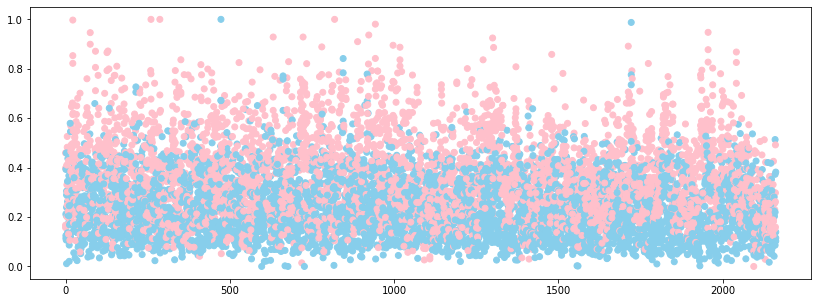

In [ ]:
for i in range(niter):
    ### get batch x, y ###
    x, y = train_data_generator.__next__()
    ### train disciminator ###
    d.trainable = True
    fake_x = g.predict(x)
    d_x = np.concatenate([x, fake_x], axis=0)
    d_y = np.concatenate([np.zeros(len(x)), np.ones(len(fake_x))], axis=0)
    d_loss = d.train_on_batch(d_x, d_y)
    ### train generator ###
    d.trainable = False 
    g_loss = gan_trainer.train_on_batch(x, y)
    #g_loss include adv cnt enc loss, and what is last one ? = total loss

    if i % 50 == 0:
      print(f'niter: {i+1}, g_loss: {g_loss}, d_loss: {d_loss}')
      total_loss.append(g_loss[0])
      dis_loss.append(round(d_loss,7))


# Evaluation

In [ ]:
np.min(x_test)

-1.0

In [ ]:
from PIL import Image

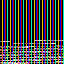

In [ ]:
Image.fromarray(x_test[0], mode='RGB')

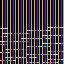

In [ ]:
Image.fromarray(x_ok[3], mode='RGB')

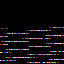

In [ ]:
Image.fromarray(x_ok[3]+1, mode='RGB')

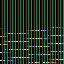

In [ ]:
Image.fromarray((x_ok[3]+1 *127), mode='RGB')

In [ ]:
x_ok[3].shape

(64, 64, 1)

In [ ]:
Image.frombytes(mode='RGB', size=(64,64), x_ok[3])

SyntaxError: ignored

In [ ]:
Image.fromarray(x_test[0],'1')

ValueError: ignored

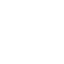

In [ ]:
Image.new('1', (64,64), color=1)

In [ ]:
x_test[0].shape

(64, 64, 1)

In [ ]:
from PIL import Image
Image.fromarray(x_train[0])

In [ ]:
x_train[0].shape

(28, 28)

In [ ]:
encoded = g_e.predict(x_test)
gan_x = g.predict(x_test)
encoded_gan = g_e.predict(gan_x)
score = np.sum(np.absolute(encoded - encoded_gan), axis=-1)
score = (score - np.min(score)) / (np.max(score) - np.min(score)) # map to 0~1

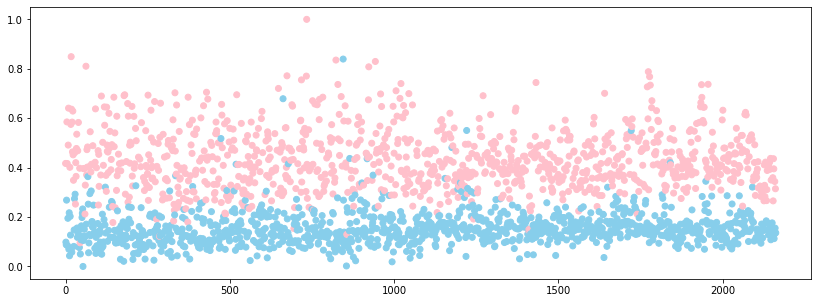

In [ ]:
from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5
plt.scatter(range(len(x_test)), score, c=['skyblue' if x == 1 else 'pink' for x in y_test])

niter: 1, g_loss: [1.1897607, 0.22251047, 0.037441127, 0.019983353], d_loss: 0.4711008667945862
niter: 51, g_loss: [1.29652, 0.24384803, 0.04173042, 0.01783961], d_loss: 0.32006147503852844
niter: 101, g_loss: [1.2674772, 0.2560714, 0.039836854, 0.02273769], d_loss: 0.28387922048568726
niter: 151, g_loss: [1.3252466, 0.23640233, 0.042941265, 0.021350909], d_loss: 0.35987138748168945
niter: 201, g_loss: [1.2281862, 0.23326784, 0.0385073, 0.021672305], d_loss: 0.41755667328834534
niter: 251, g_loss: [1.2601789, 0.27163962, 0.03824716, 0.020877337], d_loss: 0.4005073010921478
niter: 301, g_loss: [1.3741014, 0.27842218, 0.04337731, 0.02058551], d_loss: 0.2309999018907547
niter: 351, g_loss: [1.1887515, 0.19322738, 0.03804401, 0.02555028], d_loss: 0.17530758678913116
niter: 401, g_loss: [1.3014538, 0.19134986, 0.04371382, 0.017593527], d_loss: 0.13849903643131256
niter: 451, g_loss: [1.0826272, 0.17595313, 0.034062505, 0.016810972], d_loss: 0.08748038858175278
niter: 501, g_loss: [1.4065193

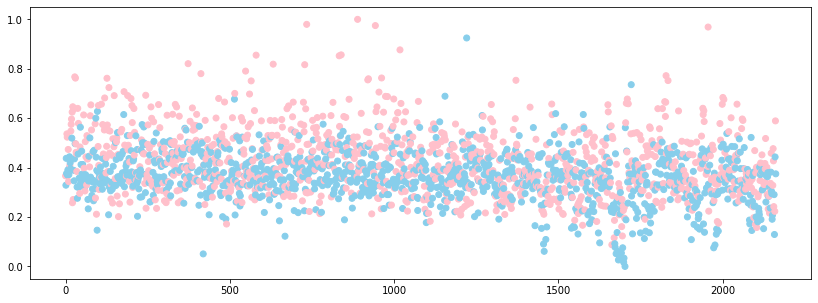

In [ ]:
niter = 9000
bz = 32

for i in range(niter):
    ### get batch x, y ###
    x, y = train_data_generator.__next__()
    ### train disciminator ###
    d.trainable = True
    fake_x = g.predict(x)
    d_x = np.concatenate([x, fake_x], axis=0)
    d_y = np.concatenate([np.zeros(len(x)), np.ones(len(fake_x))], axis=0)
    d_loss = d.train_on_batch(d_x, d_y)
    ### train generator ###
    d.trainable = False 
    g_loss = gan_trainer.train_on_batch(x, y)
    #g_loss include adv cnt enc loss, and what is last one ?

    if i % 50 == 0:
        print(f'niter: {i+1}, g_loss: {g_loss}, d_loss: {d_loss}')

encoded = g_e.predict(x_test)
gan_x = g.predict(x_test)
encoded_gan = g_e.predict(gan_x)
score = np.sum(np.absolute(encoded - encoded_gan), axis=-1)
score = (score - np.min(score)) / (np.max(score) - np.min(score)) # map to 0~1

from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5
plt.scatter(range(len(x_test)), score, c=['skyblue' if x == 1 else 'pink' for x in y_test])

#sum 10000

niter: 1, g_loss: [1.197441, 0.38744003, 0.032049607, 0.014088954], d_loss: 0.16710753738880157
niter: 51, g_loss: [1.1195471, 0.37526512, 0.028697375, 0.014800078], d_loss: 0.1458689570426941
niter: 101, g_loss: [0.8953226, 0.26056117, 0.023300987, 0.01160085], d_loss: 0.09428654611110687
niter: 151, g_loss: [1.0523285, 0.37998888, 0.025229894, 0.013105504], d_loss: 0.21617045998573303
niter: 201, g_loss: [1.1348318, 0.3658854, 0.03016893, 0.012513555], d_loss: 0.1346706748008728
niter: 251, g_loss: [1.0130643, 0.375923, 0.023477409, 0.012529539], d_loss: 0.1110629215836525
niter: 301, g_loss: [1.0481077, 0.34299546, 0.026894446, 0.012783698], d_loss: 0.21186771988868713
niter: 351, g_loss: [1.1243649, 0.37566513, 0.028492702, 0.015807746], d_loss: 0.13340497016906738
niter: 401, g_loss: [0.9843733, 0.3566829, 0.022933953, 0.013202502], d_loss: 0.10153074562549591
niter: 451, g_loss: [1.1408672, 0.2536494, 0.035926655, 0.011713989], d_loss: 0.11195872724056244
niter: 501, g_loss: [1.1

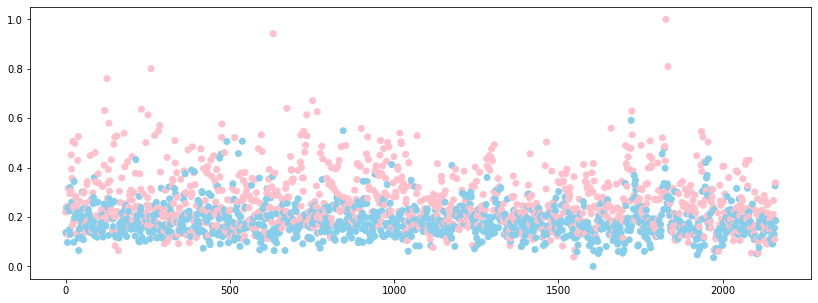

In [ ]:
niter = 10000
bz = 32

for i in range(niter):
    ### get batch x, y ###
    x, y = train_data_generator.__next__()
    ### train disciminator ###
    d.trainable = True
    fake_x = g.predict(x)
    d_x = np.concatenate([x, fake_x], axis=0)
    d_y = np.concatenate([np.zeros(len(x)), np.ones(len(fake_x))], axis=0)
    d_loss = d.train_on_batch(d_x, d_y)
    ### train generator ###
    d.trainable = False 
    g_loss = gan_trainer.train_on_batch(x, y)
    #g_loss include adv cnt enc loss, and what is last one ?

    if i % 50 == 0:
        print(f'niter: {i+1}, g_loss: {g_loss}, d_loss: {d_loss}')

encoded = g_e.predict(x_test)
gan_x = g.predict(x_test)
encoded_gan = g_e.predict(gan_x)
score = np.sum(np.absolute(encoded - encoded_gan), axis=-1)
score = (score - np.min(score)) / (np.max(score) - np.min(score)) # map to 0~1

from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5
plt.scatter(range(len(x_test)), score, c=['skyblue' if x == 1 else 'pink' for x in y_test])

#sum 20000

niter: 1, g_loss: [0.9963432, 0.35373563, 0.024216177, 0.011141112], d_loss: 0.039666756987571716
niter: 51, g_loss: [1.1353688, 0.4095299, 0.028297039, 0.014265674], d_loss: 0.033267032355070114
niter: 101, g_loss: [0.86652774, 0.2709152, 0.021781666, 0.010998711], d_loss: 0.02956618368625641
niter: 151, g_loss: [1.1105758, 0.37747055, 0.02837922, 0.0128383385], d_loss: 0.03991372510790825
niter: 201, g_loss: [1.0545858, 0.42785522, 0.023102101, 0.012474595], d_loss: 0.04761732369661331
niter: 251, g_loss: [1.2118435, 0.4040838, 0.031911366, 0.01341723], d_loss: 0.03554735332727432
niter: 301, g_loss: [1.078293, 0.42835343, 0.02431937, 0.012781617], d_loss: 0.028833692893385887
niter: 351, g_loss: [1.0398178, 0.42864275, 0.022594105, 0.012496812], d_loss: 0.03163779154419899
niter: 401, g_loss: [1.2257953, 0.4169457, 0.032125227, 0.012734836], d_loss: 0.028798574581742287
niter: 451, g_loss: [1.1103603, 0.38599652, 0.028059803, 0.011830889], d_loss: 0.03841383010149002
niter: 501, g_l

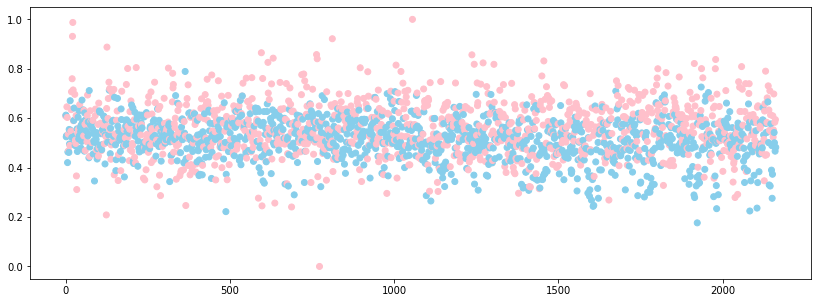

In [ ]:
niter = 80000
bz = 32

for i in range(niter):
    ### get batch x, y ###
    x, y = train_data_generator.__next__()
    ### train disciminator ###
    d.trainable = True
    fake_x = g.predict(x)
    d_x = np.concatenate([x, fake_x], axis=0)
    d_y = np.concatenate([np.zeros(len(x)), np.ones(len(fake_x))], axis=0)
    d_loss = d.train_on_batch(d_x, d_y)
    ### train generator ###
    d.trainable = False 
    g_loss = gan_trainer.train_on_batch(x, y)
    #g_loss include adv cnt enc loss, and what is last one ?

    if i % 50 == 0:
        print(f'niter: {i+1}, g_loss: {g_loss}, d_loss: {d_loss}')

encoded = g_e.predict(x_test)
gan_x = g.predict(x_test)
encoded_gan = g_e.predict(gan_x)
score = np.sum(np.absolute(encoded - encoded_gan), axis=-1)
score = (score - np.min(score)) / (np.max(score) - np.min(score)) # map to 0~1

from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5
plt.scatter(range(len(x_test)), score, c=['skyblue' if x == 1 else 'pink' for x in y_test])

#sum 100000

In [ ]:
niter = 400000
bz = 32

for i in range(niter):
    ### get batch x, y ###
    x, y = train_data_generator.__next__()
    ### train disciminator ###
    d.trainable = True
    fake_x = g.predict(x)
    d_x = np.concatenate([x, fake_x], axis=0)
    d_y = np.concatenate([np.zeros(len(x)), np.ones(len(fake_x))], axis=0)
    d_loss = d.train_on_batch(d_x, d_y)
    ### train generator ###
    d.trainable = False 
    g_loss = gan_trainer.train_on_batch(x, y)
    #g_loss include adv cnt enc loss, and what is last one ?

    if i % 50 == 0:
        print(f'niter: {i+1}, g_loss: {g_loss}, d_loss: {d_loss}')

encoded = g_e.predict(x_test)
gan_x = g.predict(x_test)
encoded_gan = g_e.predict(gan_x)
score = np.sum(np.absolute(encoded - encoded_gan), axis=-1)
score = (score - np.min(score)) / (np.max(score) - np.min(score)) # map to 0~1

from matplotlib import pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 14, 5
plt.scatter(range(len(x_test)), score, c=['skyblue' if x == 1 else 'pink' for x in y_test])

##sum 500000

niter: 1, g_loss: [0.88702583, 0.34785572, 0.01988516, 0.012744815], d_loss: 0.015004721470177174
niter: 51, g_loss: [0.9437349, 0.35424346, 0.022419188, 0.012915849], d_loss: 0.014124168083071709
niter: 101, g_loss: [1.0093604, 0.36549634, 0.025109723, 0.011903288], d_loss: 0.014385009184479713
niter: 151, g_loss: [0.8981379, 0.35929546, 0.019831333, 0.011858188], d_loss: 0.022981762886047363
niter: 201, g_loss: [0.8179412, 0.31652346, 0.017895766, 0.0109656835], d_loss: 0.01530655100941658
niter: 251, g_loss: [0.9232003, 0.36732563, 0.020754358, 0.011655561], d_loss: 0.01347788143903017
niter: 301, g_loss: [0.89221567, 0.33039236, 0.021090552, 0.010628939], d_loss: 0.09949232637882233
niter: 351, g_loss: [0.8810399, 0.32280234, 0.020800056, 0.012168048], d_loss: 0.04624660685658455
niter: 401, g_loss: [0.9161256, 0.37811878, 0.019877557, 0.011643201], d_loss: 0.0262113306671381
niter: 451, g_loss: [0.9676676, 0.40610707, 0.021032456, 0.012241361], d_loss: 0.019061485305428505
niter: 

In [ ]:
i=4
y_test[i:i+1]

In [ ]:
image = np.reshape(gan_x[i:i+1], (64, 64))
image = image * 127 + 127
plt.imshow(image.astype(np.uint8), cmap='gray')

In [ ]:
image = np.reshape(x_test[i:i+1], (64, 64))
image = image * 127 + 127
plt.imshow(image.astype(np.uint8), cmap='gray')

In [ ]:
i=1
y_test[i:i+1]

In [ ]:
image = np.reshape(gan_x[i:i+1], (64, 64))
image = image * 127 + 127
plt.imshow(image.astype(np.uint8), cmap='gray')

In [ ]:
image = np.reshape(x_test[i:i+1], (64, 64))
image = image * 127 + 127
plt.imshow(image.astype(np.uint8), cmap='gray')

In [ ]:
#x_ok = x_train[y_train == 1]

(x_train2, y_train2), (x_test2, y_test2) = mnist.load_data()

x_test_7 = x_test2[y_test2 == 7]
x_test_7 = reshape_x(x_test_7)

x_test_1 = x_test2[y_test2 == 1]
x_test_1 = reshape_x(x_test_1)

y_test_7 = y_test2[y_test2 == 7]
y_test_1 = y_test2[y_test2 == 1]

In [ ]:
encoded = g_e.predict(x_test_7)
gan_x = g.predict(x_test_7)
encoded_gan = g_e.predict(gan_x)
score = np.sum(np.absolute(encoded - encoded_gan), axis=-1)
score = (score - np.min(score)) / (np.max(score) - np.min(score)) # map to 0~1

In [ ]:
score_7=score

In [ ]:
encoded = g_e.predict(x_test_1)
gan_x = g.predict(x_test_1)
encoded_gan = g_e.predict(gan_x)
score = np.sum(np.absolute(encoded - encoded_gan), axis=-1)
score = (score - np.min(score)) / (np.max(score) - np.min(score)) # map to 0~1

In [ ]:
score_ok_1=score

In [ ]:


sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set1')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

labels = ['lab_ok_1', 'lab_7']
ax.hist(score_ok_1, bins=50, alpha=0.6,label=labels[0])
ax.hist(score_7, bins=50, alpha=0.6,label=labels[1])
ax.set_xlabel('length [cm]')

plt.legend()
plt.show()

In [ ]:
#x_ok = x_train[y_train == 1]

(x_train2, y_train2), (x_test2, y_test2) = mnist.load_data()

x_test_5 = x_test2[y_test2 == 5]
x_test_5 = reshape_x(x_test_5)

x_test_1 = x_test2[y_test2 == 1]
x_test_1 = reshape_x(x_test_1)

y_test_5 = y_test2[y_test2 == 5]
y_test_1 = y_test2[y_test2 == 1]

In [ ]:
encoded = g_e.predict(x_test_5)
gan_x = g.predict(x_test_5)
encoded_gan = g_e.predict(gan_x)
score = np.sum(np.absolute(encoded - encoded_gan), axis=-1)
score = (score - np.min(score)) / (np.max(score) - np.min(score)) # map to 0~1

In [ ]:
score_5=score

In [ ]:
encoded = g_e.predict(x_test_1)
gan_x = g.predict(x_test_1)
encoded_gan = g_e.predict(gan_x)
score = np.sum(np.absolute(encoded - encoded_gan), axis=-1)
score = (score - np.min(score)) / (np.max(score) - np.min(score)) # map to 0~1

In [ ]:
score_1=score

In [ ]:

import seaborn as sns

sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set1')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

labels = ['lab_1', 'lab_5']
ax.hist(score_1, bins=50, alpha=0.6,label=labels[0])
ax.hist(score_5, bins=50, alpha=0.6,label=labels[1])
ax.set_xlabel('length [cm]')

plt.legend()
plt.show()

In [ ]:
#学習回数が少なすぎると1の画像が正規分布しない
#何回学習したら綺麗に分かれるのか上で検証してみる

In [ ]:
g.save_weights('g.h5')

In [ ]:
g_e.save_weights('g_e.h5')

In [ ]:
from keras import layers
import keras
import keras.backend as K


import numpy as np
import seaborn as sns

In [ ]:
width = 64
height = 64
channels = 1

In [ ]:
input_layer = layers.Input(name='input', shape=(height, width, channels))

# Encoder
x = layers.Conv2D(32, (5,5), strides=(1,1), padding='same', name='conv_1', kernel_regularizer = 'l2')(input_layer)
x = layers.LeakyReLU(name='leaky_1')(x)

x = layers.Conv2D(64, (3,3), strides=(2,2), padding='same', name='conv_2', kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(name='norm_1')(x)
x = layers.LeakyReLU(name='leaky_2')(x)


x = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='conv_3', kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(name='norm_2')(x)
x = layers.LeakyReLU(name='leaky_3')(x)


x = layers.Conv2D(128, (3,3), strides=(2,2), padding='same', name='conv_4', kernel_regularizer = 'l2')(x)
x = layers.BatchNormalization(name='norm_3')(x)
x = layers.LeakyReLU(name='leaky_4')(x)

x = layers.GlobalAveragePooling2D(name='g_encoder_output')(x)

g_e = keras.models.Model(inputs=input_layer, outputs=x)

g_e.summary()

In [ ]:
input_layer = layers.Input(name='input', shape=(height, width, channels))

x = g_e(input_layer)

y = layers.Dense(width * width * 2, name='dense')(x) # 2 = 128 / 8 / 8
y = layers.Reshape((width//8, width//8, 128), name='de_reshape')(y)

y = layers.Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', name='deconv_1', kernel_regularizer = 'l2')(y)
y = layers.LeakyReLU(name='de_leaky_1')(y)

y = layers.Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', name='deconv_2', kernel_regularizer = 'l2')(y)
y = layers.LeakyReLU(name='de_leaky_2')(y)

y = layers.Conv2DTranspose(32, (3,3), strides=(2,2), padding='same', name='deconv_3', kernel_regularizer = 'l2')(y)
y = layers.LeakyReLU(name='de_leaky_3')(y)

y = layers.Conv2DTranspose(channels, (1, 1), strides=(1,1), padding='same', name='decoder_deconv_output', kernel_regularizer = 'l2', activation='tanh')(y)

g = keras.models.Model(inputs=input_layer, outputs=y)

g.summary()

In [ ]:
g.load_weights('g.h5')

In [ ]:
g_e.load_weights('g_e.h5')

In [ ]:
from keras.datasets import mnist
import cv2
import numpy as np



In [ ]:
def reshape_x(x):
    new_x = np.empty((len(x), width, height))
    for i, e in enumerate(x):
        new_x[i] = cv2.resize(e, (width, height))
    return np.expand_dims(new_x, axis=-1) / 127 - 1
  

In [ ]:

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_test_6 = x_test[y_test == 6]
x_test_6 = reshape_x(x_test_6)

x_test_1 = x_test[y_test == 1]
x_test_1 = reshape_x(x_test_1)

y_test_6 = y_test[y_test == 6]
y_test_1 = y_test[y_test == 1]

In [ ]:
encoded = g_e.predict(x_test_6)
gan_x = g.predict(x_test_6)
encoded_gan = g_e.predict(gan_x)
score = np.sum(np.absolute(encoded - encoded_gan), axis=-1)
score = (score - np.min(score)) / (np.max(score) - np.min(score)) # map to 0~1

In [ ]:
fin_weight_score_6=score

In [ ]:
encoded = g_e.predict(x_test_1)
gan_x = g.predict(x_test_1)
encoded_gan = g_e.predict(gan_x)
score = np.sum(np.absolute(encoded - encoded_gan), axis=-1)
score = (score - np.min(score)) / (np.max(score) - np.min(score)) # map to 0~1

In [ ]:
fin_weight_score_1=score

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style('whitegrid')
sns.set_palette('Set1')

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

labels = ['fin_weight_lab_1', 'fin_weight_lab_6']
ax.hist(fin_weight_score_1, bins=50, alpha=0.6,label=labels[0])
ax.hist(fin_weight_score_6, bins=50, alpha=0.6,label=labels[1])
ax.set_xlabel('length [cm]')

plt.legend()
plt.show()